In [1]:
import pretty_midi
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import librosa.display

# For putting audio in the notebook
import IPython.display

In [2]:
folder_midi = Path().cwd()
print(folder_midi)

/home/tim/Documents/midi-explore/notebooks/scratch


In [3]:
pm = pretty_midi.PrettyMIDI(str(folder_midi / '367sonat_a1.mid'))

In [4]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

/home/tim/miniconda3/envs/midi/lib/python3.6/site-packages/librosa/display.py:1336: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  "Frequency axis exceeds Nyquist. "


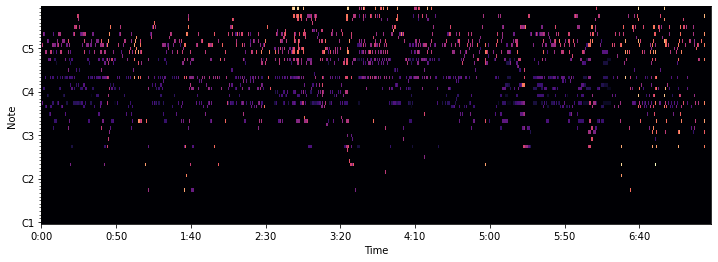

In [5]:
plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 24, 84)

In [6]:
# What's the start time of the 10th note on the 3rd instrument?
print(pm.instruments[0].notes[10].start)
# What's that in ticks?
tick = pm.time_to_tick(pm.instruments[0].notes[10].start)
print(tick)
# Note we can also go in the opposite direction
print(pm.tick_to_time(int(tick)))

1.2083333333333333
1160
1.2083333333333333


Text(0, 0.5, 'Proportion')

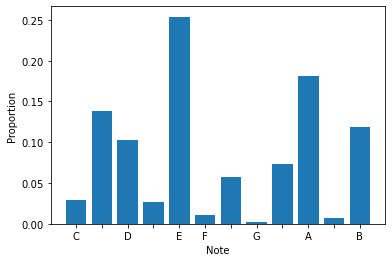

In [7]:
# Plot a pitch class distribution - sort of a proxy for key
plt.bar(np.arange(12), pm.get_pitch_class_histogram());
plt.xticks(np.arange(12), ['C', '', 'D', '', 'E', 'F', '', 'G', '', 'A', '', 'B'])
plt.xlabel('Note')
plt.ylabel('Proportion')

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sequence import NoteSeq, EventSeq, ControlSeq
import utils
import config
import optparse
from data import Dataset

path_processed_data = Path().cwd().parent.parent / 'data' / 'processed'
print(path_processed_data)

/home/tim/Documents/midi-explore/data/processed


In [100]:
batch_size = 64
window_size = 200
stride_size = 10

event_dim = EventSeq.dim()
print(event_dim)
control_dim = ControlSeq.dim()
print(control_dim)
control_ratio = 1.0

model = {
    'init_dim': 32,
    'event_dim': EventSeq.dim(),
    'control_dim': ControlSeq.dim(),
    'hidden_dim': 512,
    'gru_layers': 3,
    'gru_dropout': 0.3,
}

init_dim = model['init_dim']
event_embedding = nn.Embedding(event_dim, event_dim)
primary_event = model['event_dim'] - 1
use_transposition = False

240
24


In [97]:
dataset = Dataset(str(path_processed_data), verbose=True)
dataset_size = len(dataset.samples)
print(dataset_size)

def get_primary_event(batch_size):
        return torch.LongTensor([[primary_event] * batch_size])

def expand_controls(controls, steps):
        # [1 or steps, batch_size, control_dim]
        assert len(controls.shape) == 3
        assert controls.shape[2] == control_dim
        if controls.shape[0] > 1:
                assert controls.shape[0] >= steps
                return controls[:steps]
        return controls.repeat(steps, 1, 1)

133


In [98]:
batch_gen = dataset.batches(batch_size, window_size, stride_size)

for iteration, (events, controls) in enumerate(batch_gen):
    if use_transposition:
        offset = np.random.choice(np.arange(-6, 6))
        events, controls = utils.transposition(events, controls, offset)

    events = torch.LongTensor(events)
    assert events.shape[0] == window_size

    if np.random.random() < control_ratio:
        controls = torch.FloatTensor(controls)
        assert controls.shape[0] == window_size
    else:
        controls = None

    init = torch.randn(batch_size, init_dim)

    # simulate generate
        # init [batch_size, init_dim]
        # events [steps, batch_size] indeces
        # controls [1 or steps, batch_size, control_dim]
    events=events[:-1]
    steps = window_size

    batch_size = init.shape[0]
    assert init.shape[1] == init_dim
    assert steps > 0

    use_teacher_forcing = events is not None
    if use_teacher_forcing:
        assert len(events.shape) == 2
        assert events.shape[0] >= steps - 1
        events = events[:steps-1]

    event = get_primary_event(batch_size)
    use_control = controls is not None
    if use_control:
        controls = expand_controls(controls, steps)

    outputs = []
    step_iter = range(steps)

    for step in step_iter:
        control = controls[step].unsqueeze(0)

        # simulate forward loop
            # output, hidden = self.forward(event, control, hidden)
        assert len(event.shape) == 2
        assert event.shape[0] == 1
        batch_size = event.shape[1]
        event = event_embedding(event)

        if control is None:
            default = torch.ones(1, batch_size, 1)
            control = torch.zeros(1, batch_size, control_dim)
        else:
            default = torch.zeros(1, batch_size, 1)
            assert control.shape == (1, batch_size, control_dim)

        concat = torch.cat([event, default, control], -1)


    
    break

AssertionError: 

In [93]:
control.shape

torch.Size([1, 36, 24])

In [43]:
event_embedding

Embedding(240, 240)

In [44]:
batch_gen = dataset.batches(batch_size, window_size, stride_size)

In [45]:
for iteration, (events, controls) in enumerate(batch_gen):
    print(iteration, events.shape, controls.shape)
    break

0 (200, 36) (200, 36, 24)


In [48]:
for step in range(window_size):
    control = torch.tensor(controls[step]).unsqueeze(0)
    break

In [50]:
control.shape

torch.Size([1, 36, 24])

In [36]:
events[:-1].shape

(199, 36)

In [27]:
default = torch.zeros(1, batch_size, 1)
print(default.shape)


torch.Size([1, 36, 1])


In [29]:
concat = torch.cat([torch.tensor(events), default, torch.tensor(controls)], -1)

RuntimeError: Tensors must have same number of dimensions: got 2 and 3

In [22]:
print(events.shape)
events[:,1]

(200, 36)


array([ 57, 222, 148, 145, 203,  58, 203,  34, 188,  55, 203,  50, 227,
       208, 146, 122, 143, 138, 203,  58, 188,  55, 203,  50, 222, 146,
       143, 138, 203,  58, 188,  55, 203,  50, 222, 146, 143, 138, 203,
        57, 203,  36, 188,  53, 203,  48, 227, 208, 145, 124, 141, 136,
       203,  57, 188,  53, 203,  48, 222, 145, 141, 136, 203,  57, 188,
        53, 203,  48, 222, 145, 141, 136, 203,  55, 203,  24, 188,  52,
       203,  46, 227, 208, 143, 112, 140, 134, 203,  55, 188,  52, 203,
        46, 222, 143, 140, 134, 203,  55, 188,  52, 203,  46, 222, 143,
       140, 134, 203,  53, 203,  29, 188,  45, 222, 117, 203,  28, 222,
       133, 116, 203,  29, 222, 117, 203,  28, 222, 116, 203,  29, 227,
       208, 117, 227, 208, 141, 203,  65, 203,  29, 188,  57, 222, 117,
       203,  28, 222, 116, 203,  29, 222, 117, 203,  31, 222, 119, 203,
        33, 222, 121, 203,  31, 222, 119, 203,  33, 222, 121, 203,  34,
       222, 145, 122, 203,  36, 188,  55, 222, 124, 203,  35, 22

In [ ]:
default = torch.ones(1, batch_size, 1).to(device)
control = torch.zeros(1, batch_size, self.control_dim).to(device)

In [4]:
# load torch tensor from .data file
tensor_data = torch.load(path_processed_data / '241Brondo.mid-f7c79e4fd5215d926a9c012053a8419a.data')

In [10]:
tensor_data[0].shape

(10613,)

In [12]:
tensor_data[1]

array([[ 5, 79,  0, ..., 15,  0, 15],
       [ 5, 79,  0, ..., 15,  0, 15],
       [ 4, 68,  0, ..., 17,  0, 17],
       ...,
       [ 0, 21, 21, ..., 21, 21, 21],
       [ 0, 21, 21, ..., 21, 21, 21],
       [ 0, 21, 21, ..., 21, 21, 21]], dtype=uint8)